In [1]:
import cv2 
import numpy as np
import glob
import os
from itertools import combinations 
from itertools import product
import random
import matplotlib.pyplot as plt

In [2]:
import keras 
from keras.layers import Dense, MaxPooling2D, Convolution2D, Dropout, Input, Flatten, Subtract, merge,Conv2D,Lambda
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.models import Model,Sequential
#from keras.initializers.h as 
from tensorflow.keras.models import load_model
from keras.regularizers import l2 

Using TensorFlow backend.


In [3]:
model_save_path = '/tensorflow/unet_model_iitd.h5'

In [4]:
unetmodel = load_model(model_save_path)

In [5]:
def segment_image(unetmodel,img_in):
    out_mask = img_in.copy()
    img_in_4_d = np.expand_dims(img_in/255.0, axis=0)
    mask1 = unetmodel.predict(img_in_4_d)

    mask = np.squeeze(mask1)
    
    out_mask[mask <  .5] = 0
    #out_mask[mask < .5,1] = 0
    #out_mask[mask < .5,3] = 0
    
    return out_mask
    

In [6]:
        
#img1_0 = cv2.imread(path_input_images + folder_name + '/'+ str(pos_comb1[i][0]).zfill(2)+'.bmp')
#img1_0 = cv2.resize(img1_0,(128,128))
#out_img = segment_image(unetmodel,img1_0)
#plt.imshow(out_img)

In [6]:
path_input_images =  '/tensorflow/IITD Database/'

In [18]:
folder_name_list = np.sort(os.listdir(path_input_images))
out1= np.zeros((8000,128,128,3),'float')
out2= np.zeros((8000,128,128,3),'float')

pos_comb1 = np.array(list(combinations([1, 2, 3, 4, 5], 2)))
pos_comb2 = np.array(list(combinations([6, 7, 8, 9, 10], 2)))

neg_comb1 = np.array(list(product([2,3,4,5], [8,9,10])))

count = 0
y = []
for folder_name in folder_name_list[:200]:
    
    for i in range (len(pos_comb1)):
        
        img1_0 = cv2.imread(path_input_images + folder_name + '/'+ str(pos_comb1[i][0]).zfill(2)+'.bmp')
        img1_0 = cv2.resize(img1_0,(128,128))
        img1_0 = segment_image(unetmodel,img1_0)
        
        
        img1_1 = cv2.imread(path_input_images + folder_name + '/'+ str(pos_comb1[i][1]).zfill(2)+'.bmp')
        img1_1 = cv2.resize(img1_1,(128,128))
        img1_1 = segment_image(unetmodel,img1_1)
        out1[count]  = img1_0
        out2[count]  = img1_1
        count = count+1
        y.append(0.0)
        
        img2_0 = cv2.imread(path_input_images + folder_name + '/'+ str(pos_comb2[i][0]).zfill(2)+'.bmp')
        img2_1 = cv2.imread(path_input_images + folder_name + '/'+ str(pos_comb2[i][1]).zfill(2)+'.bmp')
        img2_0 = cv2.resize(img2_0,(128,128))
        img2_1 = cv2.resize(img2_1,(128,128))
        img2_0 = segment_image(unetmodel,img2_0)
        img2_1 = segment_image(unetmodel,img2_1)
        
        out1[count]  = img2_0
        out2[count]  = img2_1
        y.append(0.0)
        count = count+1
        
        img3_0 = cv2.imread(path_input_images + folder_name + '/'+ str(neg_comb1[i][0]).zfill(2)+'.bmp')
        img3_1 = cv2.imread(path_input_images + folder_name + '/'+ str(neg_comb1[i][1]).zfill(2)+'.bmp') 
        
        img3_0 = cv2.resize(img3_0,(128,128))
        img3_1 = cv2.resize(img3_1,(128,128))
        img3_0 = segment_image(unetmodel,img3_0)
        img3_1 = segment_image(unetmodel,img3_1)        
        out1[count]  = img3_0
        out2[count]  = img3_1
        y.append(1.0)
        count = count+1
        
        folder_name1 = str(int(folder_name) + 3).zfill(3) 
        
        img4_0 = cv2.imread(path_input_images + folder_name + '/'+ str(pos_comb1[i][0]).zfill(2)+'.bmp')
        img4_1 = cv2.imread(path_input_images + folder_name1 + '/'+ str(pos_comb1[i][1]).zfill(2)+'.bmp') 
        img4_0 = cv2.resize(img4_0,(128,128))
        img4_1 = cv2.resize(img4_1,(128,128))
        img4_0 = segment_image(unetmodel,img4_0)
        img4_1 = segment_image(unetmodel,img4_1)           
        out1[count]  = img4_0
        out2[count]  = img4_1
        y.append(1.0)
        count = count+1
        #print(count) 

In [19]:

out1 = out1/255.
out2 = out2/255.

In [10]:
print ("X_train shape: " + str(out1.shape))


X_train shape: (8000, 128, 128, 3)


In [11]:
path_input_images + folder_name + '/'+ str(neg_comb1[1][0]).zfill(2)+'.bmp'

'/tensorflow/IITD Database/200/02.bmp'

In [12]:
path_input_images + folder_name + '/'+ str(neg_comb1[1][1]).zfill(2)+'.bmp'

'/tensorflow/IITD Database/200/09.bmp'

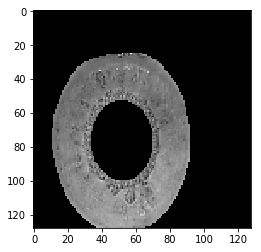

In [13]:
plt.imshow(out1[3])

In [14]:
initialize_weights = 'he_normal'
initialize_bias = 'he_normal'

In [15]:
def Siamese_model(input_shape):
    """
        Model architecture
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction,name='Siamese_model')
    
    # return the model
    return siamese_net

In [16]:
siamese_model = Siamese_model((128,128,3))

In [17]:
siamese_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 4096)         68320576    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 4096)         0           sequential_1[1][0]               
          

In [18]:
optimizer = keras.optimizers.Adam(lr = 0.00006)
siamese_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics = ["accuracy"])
#siamese_model.compile(loss='binary_crossentropy',optimizer=keras.optimizers.SGD(lr=0.001),metrics = ['accuracy'])


In [19]:
siamese_model.fit([out1,out2],y,epochs=100, batch_size = 4)

Epoch 1/100
8000/8000 [==============================] - 273s 34ms/step - loss: 1.8635 - acc: 0.8675
Epoch 2/100
8000/8000 [==============================] - 267s 33ms/step - loss: 0.5988 - acc: 0.9517
Epoch 3/100
8000/8000 [==============================] - 268s 33ms/step - loss: 0.4061 - acc: 0.9700
Epoch 4/100
8000/8000 [==============================] - 269s 34ms/step - loss: 0.3419 - acc: 0.9782
Epoch 5/100
8000/8000 [==============================] - 267s 33ms/step - loss: 0.3037 - acc: 0.9830
Epoch 6/100
8000/8000 [==============================] - 264s 33ms/step - loss: 0.2881 - acc: 0.9829
Epoch 7/100
8000/8000 [==============================] - 264s 33ms/step - loss: 0.2507 - acc: 0.9869
Epoch 8/100
8000/8000 [==============================] - 264s 33ms/step - loss: 0.2466 - acc: 0.9864
Epoch 9/100
8000/8000 [==============================] - 264s 33ms/step - loss: 0.2239 - acc: 0.9876
Epoch 10/100
8000/8000 [==============================] - 264s 33ms/step - loss: 0.2032 - a

In [7]:
model_save_path = '/tensorflow/siamese_model_images_seg.h5'

#siamese_model.save(model_save_path)

In [8]:
siamese_model = load_model(model_save_path)

In [9]:
folder_name_list = np.sort(os.listdir(path_input_images))
out1_test= np.zeros((600,128,128,3),'float')
out2_test= np.zeros((600,128,128,3),'float')

pos_comb1 = np.array(list(combinations([1, 2, 3, 4, 5], 2)))
pos_comb2 = np.array(list(combinations([6, 7, 8, 9, 10], 2)))

neg_comb1 = np.array(list(product([2,3,4,5], [8,9,10])))

count = 0
y_test = []
for folder_name in folder_name_list[200:220]:
    
    for i in range (len(pos_comb1)):
        
        img1_0 = cv2.imread(path_input_images + folder_name + '/'+ str(pos_comb1[i][0]).zfill(2)+'.bmp')
        img1_0 = cv2.resize(img1_0,(128,128))
        img1_0 = segment_image(unetmodel,img1_0)
        
        
        img1_1 = cv2.imread(path_input_images + folder_name + '/'+ str(pos_comb1[i][1]).zfill(2)+'.bmp')
        img1_1 = cv2.resize(img1_1,(128,128))
        img1_1 = segment_image(unetmodel,img1_1)
        out1_test[count]  = img1_0
        out2_test[count]  = img1_1
        count = count+1
        y_test.append(0.0)
        
        img2_0 = cv2.imread(path_input_images + folder_name + '/'+ str(pos_comb2[i][0]).zfill(2)+'.bmp')
        img2_1 = cv2.imread(path_input_images + folder_name + '/'+ str(pos_comb2[i][1]).zfill(2)+'.bmp')
        img2_0 = cv2.resize(img2_0,(128,128))
        img2_1 = cv2.resize(img2_1,(128,128))
        img2_0 = segment_image(unetmodel,img2_0)
        img2_1 = segment_image(unetmodel,img2_1)
        
        out1_test[count]  = img2_0
        out2_test[count]  = img2_1
        y_test.append(0.0)
        count = count+1
        
        #img3_0 = cv2.imread(path_input_images + folder_name + '/'+ str(neg_comb1[i][0]).zfill(2)+'.bmp')
        #img3_1 = cv2.imread(path_input_images + folder_name + '/'+ str(neg_comb1[i][1]).zfill(2)+'.bmp') 
        
        #img3_0 = cv2.resize(img3_0,(128,128))
        #img3_1 = cv2.resize(img3_1,(128,128))
        #img3_0 = segment_image(unetmodel,img3_0)
        #img3_1 = segment_image(unetmodel,img3_1)        
        #out1_test[count]  = img3_0
        #out2_test[count]  = img3_1
        #y_test.append(1.0)
        #count = count+1
        
        folder_name1 = str(int(folder_name) + 3).zfill(3) 
        
        img4_0 = cv2.imread(path_input_images + folder_name + '/'+ str(pos_comb1[i][0]).zfill(2)+'.bmp')
        img4_1 = cv2.imread(path_input_images + folder_name1 + '/'+ str(pos_comb1[i][1]).zfill(2)+'.bmp') 
        img4_0 = cv2.resize(img4_0,(128,128))
        img4_1 = cv2.resize(img4_1,(128,128))
        img4_0 = segment_image(unetmodel,img4_0)
        img4_1 = segment_image(unetmodel,img4_1)           
        out1_test[count]  = img4_0
        out2_test[count]  = img4_1
        y_test.append(1.0)
        count = count+1
        #print(count) 

In [11]:
out1_test = out1_test/255.
out2_test = out2_test/255.

In [20]:
scores = siamese_model.evaluate([out1,out2], y, verbose=0)
print(scores)

[0.042045618310570715, 0.998375]


In [12]:
scores_test = siamese_model.evaluate([out1_test,out2_test], y_test, verbose=0)
print(scores_test)

[0.4013477591176828, 0.9133333333333333]


In [13]:
print(out1_test.shape)

(600, 128, 128, 3)
